# Cash Money Soccer

## Introduction
Sports betting is increasingly popular [Source], with soccer betting market of {Money}. For our analysis, we sourced data from the Stats Bomb website, which has fine-grained data about each event in the match. These include:
* competition, match, player, team;
* pass, shot, dribble, possession;
* location, and duration of event.

The outcome we chose to focus on was the probability that any given possession would be converted to a shot. Shots were used as a proxy for goals, however the correlation is not neccessarily strong.

![Figure 1 <](Goal_Shot_Corr.png)

For our analysis, we are looking at 2 different logistic hierachical models:
1. $\eta = \mu + \beta_{Team_i, attack} - \beta_{Team_j, defend}$
2. $\eta = \mu + \beta_{Team_i, attack} - \beta_{Team_j, defend} + \beta_{Dist} \times Dist_x$

### Model Construction
The hypothesis was that each team will have some relative skill in either attacking or defending, we didn't individually consider players because too little events are recorded for each player, and more importantly, soccer is a team sport where possessions are played by the team.

### Prior Definition
Because we are looking at differences between 

## Team Ability

### Model Definition:
We're implementing a hierachical model where each team has both an attacking and defending ability with mean $\mu$ and standard deviation $\sigma_T$.    
It's a logistic model with the link function:    
$\eta = \mu + ability_T * \sigma_T$

In [39]:
import pystan as ps
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plot
import seaborn as sns
from itertools import permutations
from psis import psisloo

# Data Input

In [40]:
# dataframe of events
e = pd.read_csv('data/events.csv')
e['timestamp'] = pd.to_datetime(e['timestamp'])

# series mapping match ids to lists of unique team ids (two teams per match)
match_teams = (
    e.groupby('match_id')['possession_team_id'].unique()
    .pipe(lambda s: pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T)
    .reset_index()
)

# series mapping match id/team id pairs to opponent team ids
team_id_opp = (
    pd.concat([match_teams.set_index(['index', 0])[1],
               match_teams.set_index(['index', 1])[0]])
    .rename('possession_team_id_opp')
    .sort_index()
)
team_id_opp.index.names = ['match_id', 'team_id']

# group events by possession
possession_groups = (
    e
    .join(team_id_opp, on=['match_id', 'possession_team_id'])
    .sort_values(['match_id', 'possession', 'timestamp'])
    .groupby(['match_id', 'possession'])
)

# dataframe of possessions
possessions_ori = pd.DataFrame({
    'competition': possession_groups['competition_name'].first(),
    'team_id': possession_groups['possession_team_id'].first(),
    'team_id_opp': possession_groups['possession_team_id_opp'].first(),
    'shot': possession_groups['shot_type_id'].any(),
    'first_event_type': possession_groups['type_name'].first(),
    'x_loc': possession_groups['location_x'].first()
})

/Users/nickscomputer/.local/share/virtualenvs/BDA-Pc4H_nOL/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,21,23,26,27,28,33,51,62,66,72,83,86,92,93,96) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
possessions = possessions_ori[possessions_ori['competition'] == 'NWSL']

num_team = len(possessions['team_id'].unique())+1
Team_Link =  pd.DataFrame({'teams': possessions['team_id'].unique(), 'team_identifier': np.arange(1,num_team)})
Team_Link_opp =  pd.DataFrame({'teams': possessions['team_id'].unique(), 'team_identifier_opp': np.arange(1,num_team)})
possessions = possessions.join(Team_Link.set_index('teams'), on='team_id')
possessions = possessions.join(Team_Link_opp.set_index('teams'), on='team_id_opp')
possessions = possessions.dropna()

In [42]:
perm = permutations(np.arange(1,num_team), 2)
team_1 = list()
team_2 = list()
for comp in perm:
    team_1.append(comp[0])
    team_2.append(comp[1])

L = len(team_1)

In [43]:
df_lineups = pd.read_csv('data/lineups.csv')
df_lineups = df_lineups.drop(['player_id', 'player_name', 'player_country_id', 'player_country_name', 'jersey_number', 'match_id', 'Unnamed: 0'], axis = 1)
df_lineups = df_lineups.drop_duplicates().reset_index(drop=True)

In [44]:
possessions = possessions.join(df_lineups.set_index('team_id'), on = 'team_id')

df_lineups.columns = ['team_id', 'opposing_team']

possessions = possessions.join(df_lineups.set_index('team_id'), on = 'team_id_opp')

In [45]:
id_team_link = possessions[['team_identifier', 'team_name']].copy()
id_team_link = id_team_link.drop_duplicates().reset_index(drop=True).sort_values('team_identifier')

## Model Specification and Creation

### Attack, Defence, and Distance Model
Correlating the team differential ability ($\beta_{Team A, attack} - \beta_{Team B, defend}$), and the distance of possession ($\beta_{dist}$). Each event is modelled as a bernoulli trial with probability eta. The distance is done is such a way that it is always in terms of the distance from the opposing goal. A possession will have a binary 1 or 0, 1 if a shot or a series of shots occurs, and 

#### Model Input Specification

In [46]:
norm_xloc = (possessions['x_loc']-possessions['x_loc'].mean())/possessions['x_loc'].std()

model_input_dist = {
    'N': len(possessions),
    'team_attack': possessions['team_identifier'].astype(int),
    'team_defend': possessions['team_identifier_opp'].astype(int),
    'dist': norm_xloc,
    'k': len(Team_Link),
    'shot': possessions['shot'].astype(int),
    'L': L,
    'team_1': team_1,
    'team_2': team_2
}

In [47]:
model_dist = ps.StanModel(file = 'shot_distance_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a0f24e5115fb1c06d041f34fc454a6e NOW.


In [48]:
fit_dist = model_dist.sampling(data=model_input_dist, iter=2000, chains=4, control = {'adapt_delta': 0.99})

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [49]:
out_model_dist = az.from_pystan(fit_dist,
                          coords={'team': Team_Link['team_identifier']},
                          dims={'ability_A': ['team'],
                                'ability_B': ['team']})

In [50]:
fit_dist


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_3a0f24e5115fb1c06d041f34fc454a6e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ability_Az[1]       -0.19    0.01   0.55  -1.29  -0.56  -0.19   0.17    0.9   2500    1.0
ability_Az[2]       -0.24    0.01   0.55  -1.35  -0.59  -0.23   0.14   0.81   2216    1.0
ability_Az[3]        1.26    0.01   0.59   0.17   0.84   1.22   1.64    2.5   1564    1.0
ability_Az[4]        0.51    0.01   0.58   -0.6   0.12    0.5   0.88   1.69   1995    1.0
ability_Az[5]       -1.55    0.01   0.62  -2.83  -1.94  -1.52  -1.13  -0.39   2286    1.0
ability_Az[6]       -0.51    0.01   0.59  -1.75  -0.87  -0.51  -0.12   0.63   2698    1.0
ability_Az[7]       -0.56    0.01    0.6   -1.8  -0.95  -0.55  -0.17   0.61   2748    1.0
ability_Az[8]        0.27    0.01   0.53  -0.74  -0

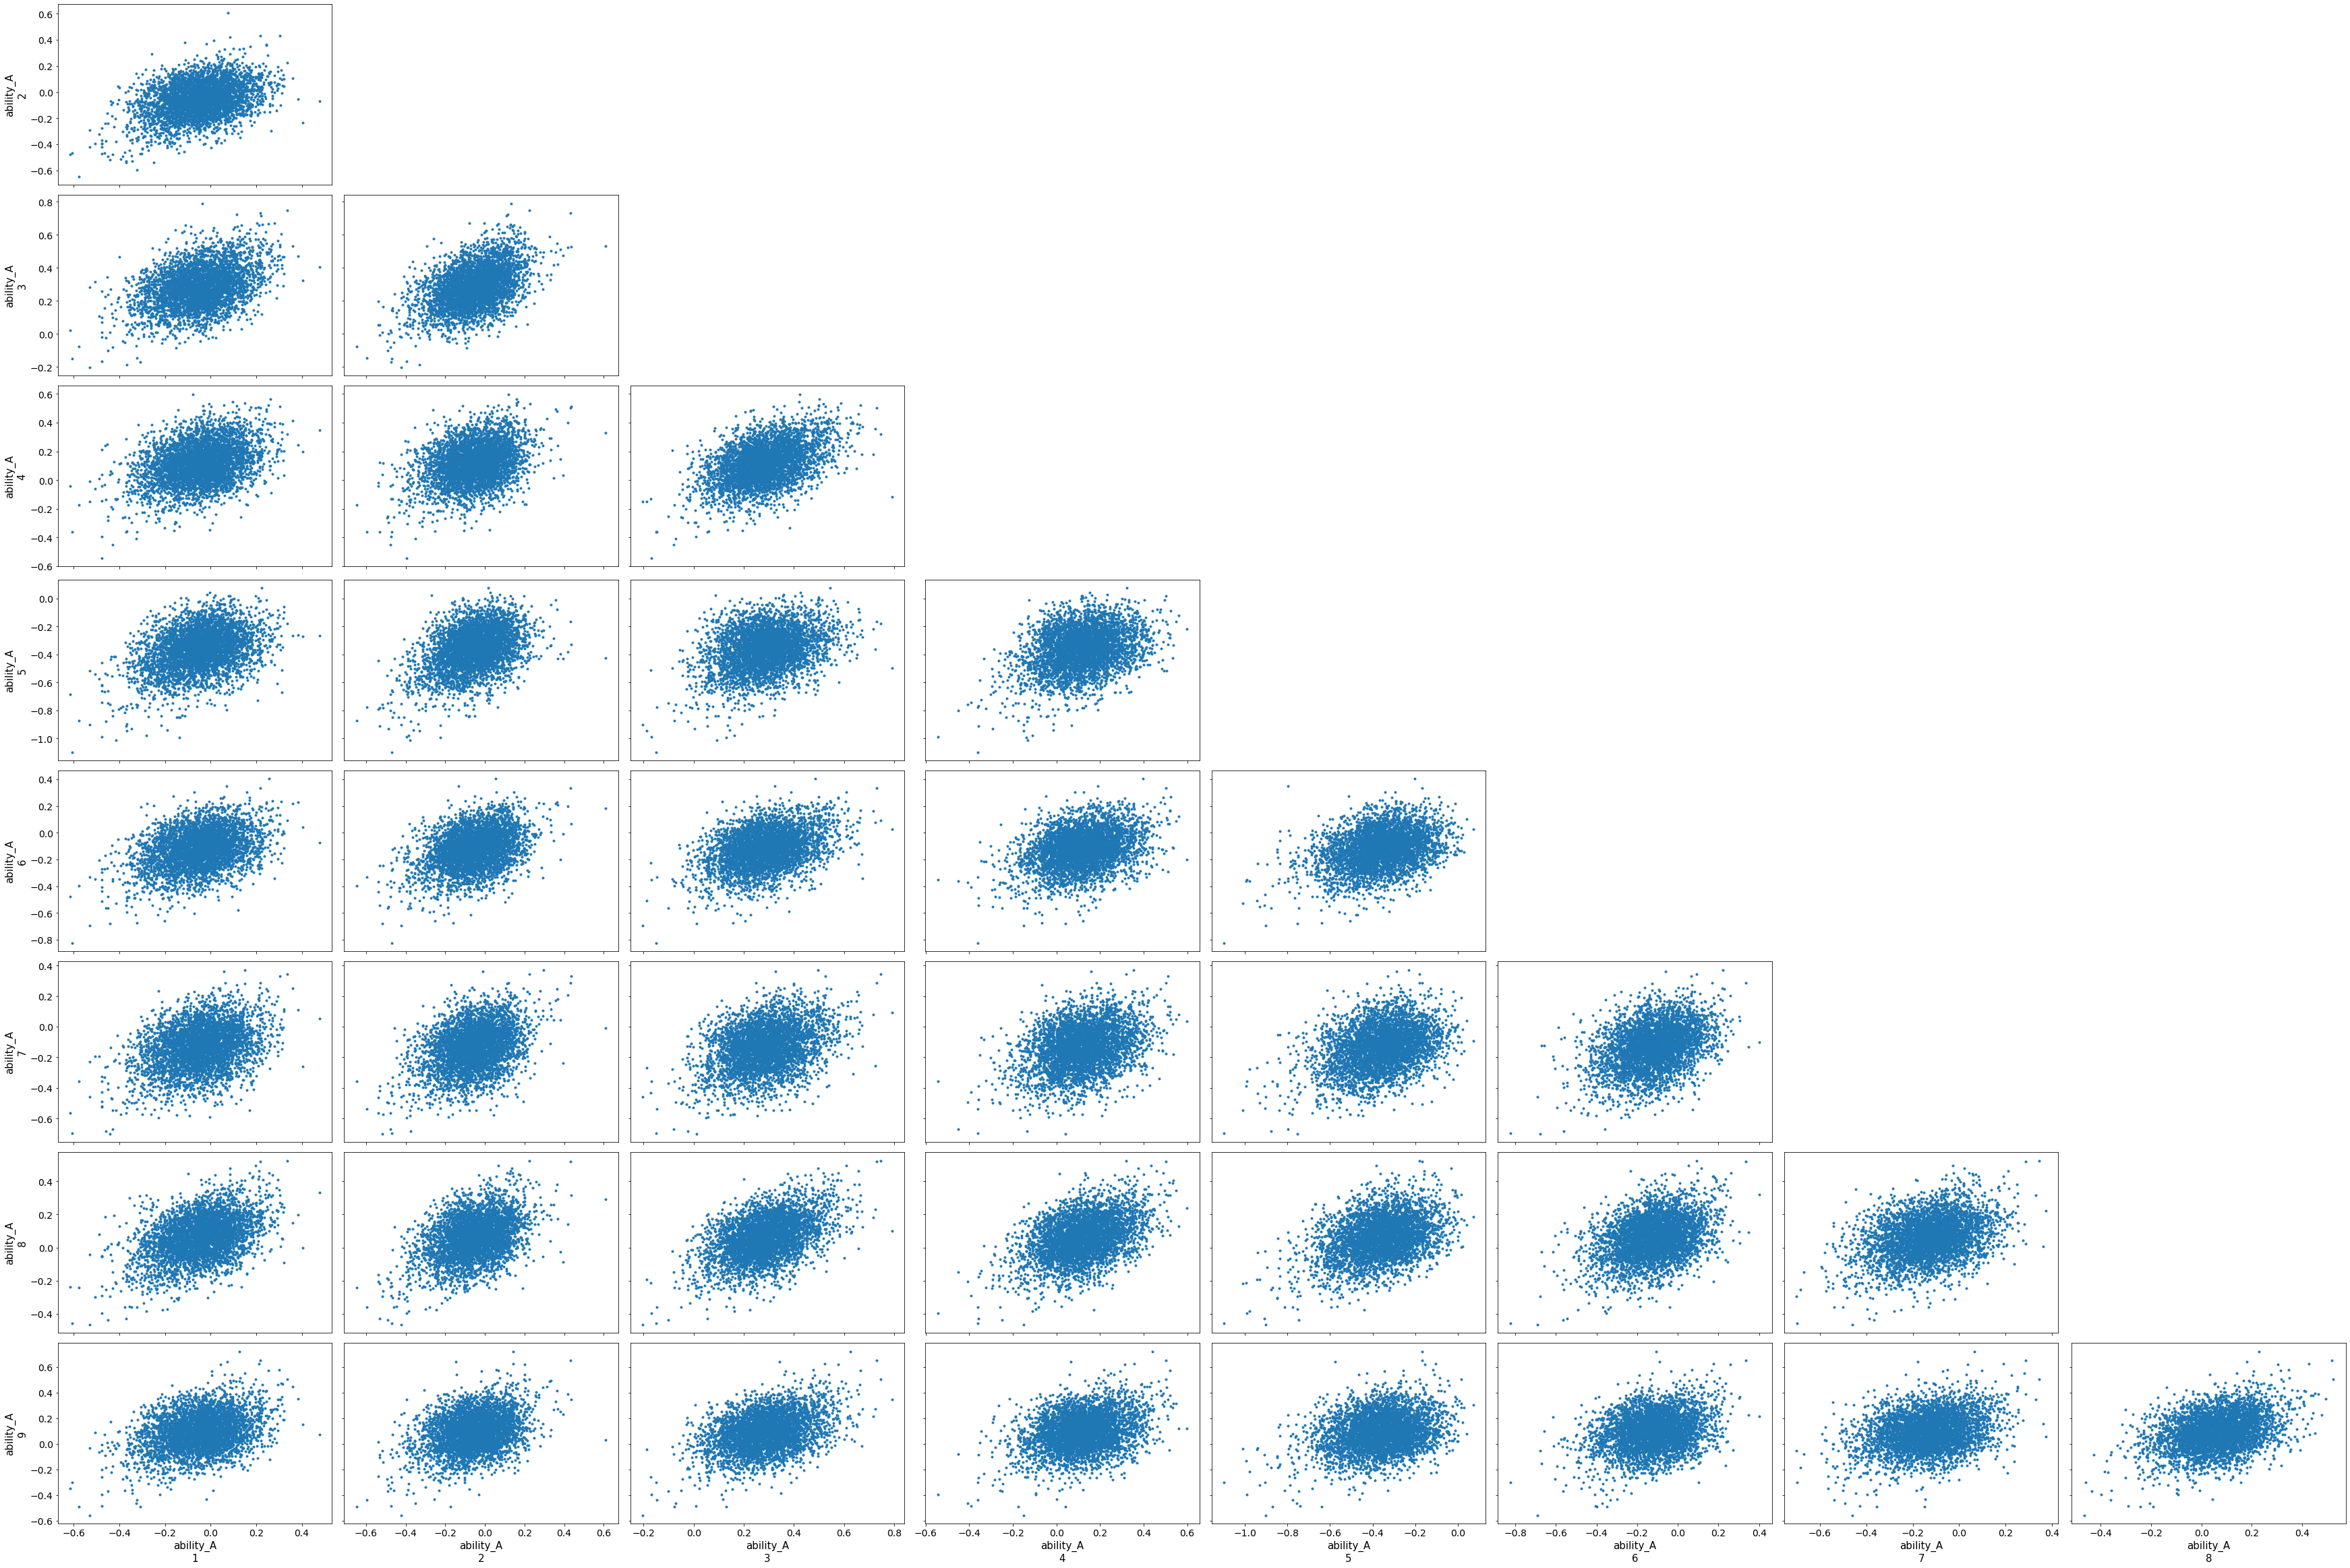

In [51]:
plots = az.plot_pair(out_model_dist, var_names=['ability_A']);

In [71]:
mean_shot_dist = fit_dist
fit_dist.par_dims

[[9],
 [9],
 [],
 [],
 [],
 [],
 [],
 [],
 [9],
 [9],
 [],
 [72],
 [9],
 [9],
 [7174],
 [7174]]

In [53]:
mean_shot_dist = fit_dist.summary()
list_ind = list()
indicator = 0
i = 0
for ind in mean_shot_dist['c_summary_rownames']:
    if 'successes_pred' in ind:
        list_ind.append(i)
        indicator = 1
    elif 'successes_pred' not in ind and indicator == 1:
        break
    i += 1

mean_shot = np.zeros([len(list_ind),1])
i = 0
for elem in mean_shot_dist['summary'][list_ind]:
    mean_shot[i] = elem[0]
    i += 1
    
    
mean_shot_dist = pd.DataFrame.from_dict({'Team1': team_1, 'Team2': team_2, 'mean_shot': mean_shot.tolist()})

KeyboardInterrupt: 

#### Constructing Heatmap

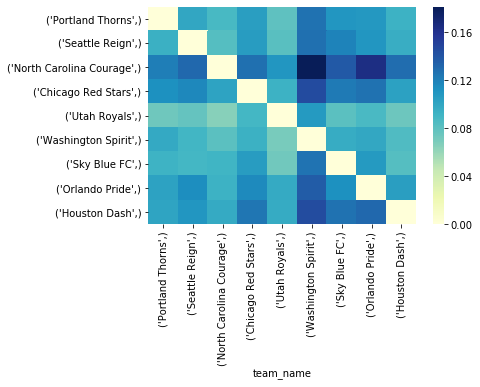

In [14]:


hm_dist = np.zeros([num_team-1, num_team-1])
for row in mean_shot_dist.iterrows():
    hm_dist[row[1][0]-1, row[1][1]-1] = row[1][2][0]

dist_df = pd.DataFrame(hm_dist)
dist_df.columns = [id_team_link['team_name']]

ax = sns.heatmap(dist_df, cmap="YlGnBu",
                xticklabels = dist_df.columns,
                yticklabels = dist_df.columns)

In [38]:
dist_df.sum(axis=1)-dist_df.sum(axis=0).values

0    0.01375
1   -0.01125
2    0.40275
3    0.05650
4   -0.04600
5   -0.38475
6   -0.13925
7   -0.05625
8    0.16450
dtype: float64

In [16]:
dist_df = pd.DataFrame(hm_dist)
dist_df.columns = [id_team_link['team_name']]

winner_df = pd.DataFrame({'team': id_team_link['team_name'],
    'score': dist_df.sum(axis=1)})

winner_df

,team,score
0,Seattle Reign,0.81275
1,Portland Thorns,0.81950
2,Chicago Red Stars,1.10475
3,North Carolina Courage,0.92625
4,Utah Royals,0.65825
5,Washington Spirit,0.71575
6,Sky Blue FC,0.77025
7,Orlando Pride,0.88050
8,Houston Dash,0.93525


In [17]:
winner_df.sort_values('score', ascending=False)

,team,score
2,Chicago Red Stars,1.10475
8,Houston Dash,0.93525
3,North Carolina Courage,0.92625
7,Orlando Pride,0.88050
1,Portland Thorns,0.81950
0,Seattle Reign,0.81275
6,Sky Blue FC,0.77025
5,Washington Spirit,0.71575
4,Utah Royals,0.65825


In [18]:
Data = fit_dist.extract()
np.save('eta',Data['pred_post'])

In [19]:
Data['pred_post'].shape

(4000, 9)

In [21]:
Data95 = pd.DataFrame(Data['pred_post'])
Data95.columns = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
sns.lineplot(data = Data95.transpose())

ValueError: These `style` levels are missing dashes: {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999}

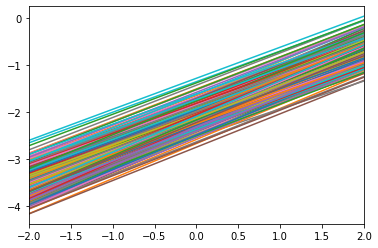

In [22]:
Data95.transpose().plot.line(legend=False)

#### Posterior Density Distributions

### Attack and Defence Model
Correlating the team differential ability ($\beta_{Team A, attack} - \beta_{Team B, defend}$). Each event is modelled as a bernoulli trial with probability eta. The distance is done is such a way that it is always in terms of the distance from the opposing goal. A possession will have a binary 1 or 0, 1 if a shot or a series of shots occurs, and 

#### Model Input Specification

In [23]:
model_input_shot = {
    'N': len(possessions),
    'team_attack': possessions['team_identifier'].astype(int),
    'team_defend': possessions['team_identifier_opp'].astype(int),
    'k': len(Team_Link),
    'shot': possessions['shot'].astype(int),
    'L': L,
    'team_1': team_1,
    'team_2': team_2
}

In [24]:
model_shot = ps.StanModel(file = 'shots_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_629e75bddb770262c4995be3d82048e7 NOW.


In [25]:
fit_shot = model_shot.sampling(data=model_input_shot, iter=2000, chains=4, control = {'adapt_delta': 0.99})

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [26]:
fit_shot


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_629e75bddb770262c4995be3d82048e7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ability_Az[1]       -0.02    0.01   0.53  -1.07  -0.37  -0.02   0.33   1.06   1896    1.0
ability_Az[2]      7.3e-3    0.01   0.54  -1.09  -0.35 9.3e-3   0.36   1.04   1953    1.0
ability_Az[3]         1.3    0.02   0.59   0.24    0.9   1.27   1.69   2.52   1488    1.0
ability_Az[4]        0.27    0.01   0.53  -0.78  -0.08   0.26   0.61   1.35   2010    1.0
ability_Az[5]       -1.51    0.01    0.6  -2.74  -1.92  -1.47  -1.08  -0.44   1753    1.0
ability_Az[6]       -0.63    0.01   0.56  -1.78  -0.98  -0.61  -0.26   0.41   2241    1.0
ability_Az[7]       -0.67    0.01   0.54  -1.83  -1.02  -0.65   -0.3   0.32   1864    1.0
ability_Az[8]        0.66    0.01   0.53  -0.33   0

In [27]:
out_model_shot = az.from_pystan(fit_shot,
                          coords={'team': Team_Link['team_identifier']},
                          dims={'ability_A': ['team'],
                                'ability_B': ['team']})

#### Constructing Heatmap

In [28]:
mean_shot_shot = fit_shot.summary()
list_ind = list()
i = 0
for ind in mean_shot_shot['c_summary_rownames']:
    if 'successes_pred' in ind:
        list_ind.append(i)
    i += 1

mean_shot = np.zeros([len(list_ind),1])
i = 0
for elem in mean_shot_shot['summary'][list_ind]:
    mean_shot[i] = elem[0]
    i += 1

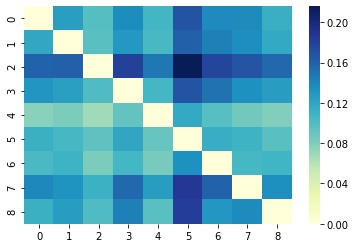

In [29]:
mean_shot_shot = pd.DataFrame.from_dict({'Team1': team_1, 'Team2': team_2, 'mean_shot': mean_shot.tolist()})

hm_shot = np.zeros([num_team-1, num_team-1])
for row in mean_shot_shot.iterrows():
    hm_shot[row[1][0]-1, row[1][1]-1] = row[1][2][0]

ax = sns.heatmap(hm_shot, cmap="YlGnBu")

## Model Comparison

In [30]:
inference_dist = az.convert_to_inference_data(fit_dist, log_likelihood='log_like')
inference_shot = az.convert_to_inference_data(fit_shot, log_likelihood='log_like')

In [31]:
model_comp={'dist_model': inference_dist,
            'ability_model': inference_shot}
az.compare(model_comp, ic='loo')

/Users/nickscomputer/.local/share/virtualenvs/BDA-Pc4H_nOL/lib/python3.7/site-packages/arviz/stats/diagnostics.py:146: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]


,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
dist_model,4938.66,15.0825,0,0.970896,106.361,0,0,deviance
ability_model,5330.29,14.1831,391.63,0.0291036,108.698,41.554,0,deviance


In [32]:
LOO_dist = psisloo(fit_dist.extract('log_like')['log_like'])
LOO_shot = psisloo(fit_shot.extract('log_like')['log_like'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134eec2e8>,
      dtype=object)

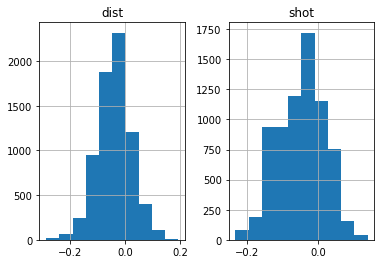

In [33]:
psis_df = pd.DataFrame({'dist': LOO_dist[2],
                        'shot': LOO_shot[2]})

psis_df.hist()